CLASS ACTIVATION MAP

In [1]:
import torch
from monai.visualize import CAM
import torch
import torchio as tio
import numpy as np
import matplotlib.pyplot as plt 
import os

# global settings
base_path = '/mnt/data_lab513/vqtran_data'
root_data = os.path.join(base_path, "data", "raw_data", "ADNI_NIfTI")
root_bias_correction = os.path.join(base_path, "data", "clean_data", "mri_bias_correction")
root_bet = os.path.join(base_path, "data", "clean_data", "mri_brain_extraction")
root_reg = os.path.join(base_path, "data", "clean_data", "mri_registration")
root_meta = os.path.join(base_path, "data", "meta_data")#, "Pre-Thesis_metadata", "ADNI") 
root_train = os.path.join(base_path, "data", "train_data")

READ IN NIFTI IMAGE AS NUMPY ARRAY

In [2]:
import nibabel as nib
sample_dir = os.path.join(root_reg,'ADNI_011_S_4912_MR_MPRAGE_br_raw_20130315145415974_174_S184571_I363474.nii.gz')
sample_img = nib.load(sample_dir)
sample_img_data = sample_img.get_fdata()
sample_img_data.shape #(182, 218, 182)
# sample_img_data.dtype  #dtype('float64')

(182, 218, 182)

CONVERT NUMPY ARRAY TO TORCH TENSOR

In [3]:
sample_image_tensor = torch.Tensor(sample_img_data)
print(sample_image_tensor.shape)
print(sample_image_tensor.dtype)

torch.Size([182, 218, 182])
torch.float32


SHOW_PLOT FUNCTIONS

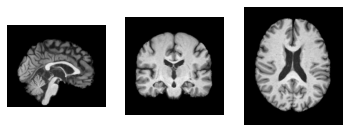

In [4]:
import matplotlib.pyplot as plt

def show_slices(slices, color = "gray"):
    """ Function to display row of image slices """
    fig, axes = plt.subplots(1, len(slices))
    
    if color == "gray" or color == "hot" or color == "summer" or color == "jet":
        for i, slice in enumerate(slices):
            plt.axis('off')
            axes[i].imshow(slice.T, cmap=color, origin="lower")
            axes[i].axis('off')
    else: 
        raise Exception("choose gray, hot, summer, or jet for color")
         
def create_and_show_slices(data_volume, color):
    if (len(data_volume.shape) == 4):
        print(data_volume.shape)
        img_data = torch.squeeze(data_volume,0)
    else:
        img_data = data_volume
        
    slice_0 = img_data[img_data.shape[0]//2, :, :]
    slice_1 = img_data[:, img_data.shape[1]//2, :]
    slice_2 = img_data[:, :, img_data.shape[2]//2]
    
    show_slices([slice_0, slice_1, slice_2], color)
    # plt.suptitle("Center slices for EPI image")  

create_and_show_slices(sample_image_tensor, "gray")

torch.Size([1, 110, 110, 110])


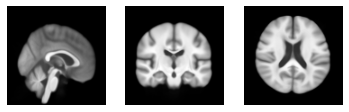

In [5]:
mean_image_AD_dir = torch.load("/home/vqtran/Thesis_structure/filter_data/mean_image_AD.pt")
create_and_show_slices(mean_image_AD_dir, "gray")

torch.Size([1, 110, 110, 110])


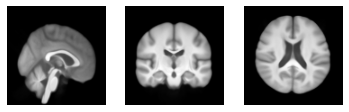

In [6]:
mean_image_EMCI_dir = torch.load("/home/vqtran/Thesis_structure/filter_data/mean_image_EMCI.pt")
create_and_show_slices(mean_image_EMCI_dir, "gray")

torch.Size([1, 110, 110, 110])


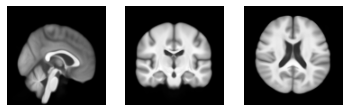

In [7]:
mean_image_CN_dir = torch.load("/home/vqtran/Thesis_structure/filter_data/mean_image_CN.pt")
create_and_show_slices(mean_image_CN_dir, "gray")

PANDAS DATAFRAME

In [8]:
import pandas as pd
DATAFRAME_DIR = "./investigate/positive_inter_class_distance_sorted_dataframe_CN_EMCI_AD.csv"
dataset_csv = pd.read_csv(DATAFRAME_DIR)
dataset_csv.tail()

,Subject ID,Image ID,Image Path,Image Target,DISTANCE CN,DISTANCE EMCI,DISTANCE AD,INTRA_CLASS_DISTANCE,INTER_CLASS_DISTANCE_CN_EMCI,INTER_CLASS_DISTANCE_CN_AD,INTER_CLASS_DISTANCE_EMCI_AD
295,013_S_5071,I360324,/mnt/data_lab513/vqtran_data/data/data_train_d...,AD,0.001839,0.002433,0.001851,0.001851,0.000570,-0.000012,0.000582
296,003_S_1059,I29252,/mnt/data_lab513/vqtran_data/data/data_train_d...,AD,0.004351,0.004653,0.004073,0.004073,0.000859,0.000278,0.000580
297,019_S_5012,I358059,/mnt/data_lab513/vqtran_data/data/data_train_d...,AD,0.002296,0.002807,0.002245,0.002245,0.000613,0.000051,0.000562
298,031_S_4024,I228879,/mnt/data_lab513/vqtran_data/data/data_train_d...,AD,0.002316,0.002896,0.002380,0.002380,0.000452,-0.000064,0.000516
299,141_S_0790,I24147,/mnt/data_lab513/vqtran_data/data/data_train_d...,AD,0.002459,0.002822,0.002331,0.002331,0.000619,0.000128,0.000491


In [9]:
dataset_csv["Image Target"].value_counts()

CN      100
EMCI    100
AD      100
Name: Image Target, dtype: int64

In [10]:
print(dataset_csv["Image Path"][42])
print(dataset_csv["Image Target"][42])

/mnt/data_lab513/vqtran_data/data/data_train_dec/unique/ADNI_022_S_0014_MR_MPRAGE_br_raw_20050930093353659_98_S9271_I7332.nii.gz
CN


Visualization

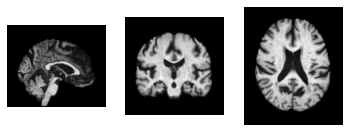

In [32]:
idx = 296
sample_dir = os.path.join(dataset_csv["Image Path"][idx])
sample_img = nib.load(sample_dir)
sample_img_data = sample_img.get_fdata()
sample_image_tensor = torch.Tensor(sample_img_data)
create_and_show_slices(sample_image_tensor, "gray")


PREDICTION

In [11]:
from predict import predict
import time

idx = 296


start_time = time.time()
my_predict, model = predict(dataset_csv["Image Path"][idx], dataset_csv["Image Target"][idx], have_root = True)
print("--- %s seconds ---" % (time.time() - start_time))

print(my_predict)


PREDICTER CONSTRUCTED
tensorboard recording at:  runs/trial_0.0
/mnt/data_lab513/vqtran_data/Model/models/trial_169.3/fold_0.pth
----- Setting up data ... -----
torch.Size([502, 110, 110, 110])
torch.Size([126, 110, 110, 110])
torch.Size([502])
torch.Size([126])
load complete
transformation of train set
use augmentation True
augmentation type Compose([RandomAffine(), RandomFlip()]) <monai.transforms.compose.Compose object at 0x7f3808a3edc0>
transformation of test set
use augmentation False
augmentation type Compose([]) <monai.transforms.compose.Compose object at 0x7f3808a27580>
number of sample in train dataloader 502
number of sample in test dataloader 126
Complete DataLoader
Keys of pretrained dict: ['module.base_model.conv1.0.weight', 'module.base_model.conv1.1.weight', 'module.base_model.conv1.1.bias', 'module.base_model.conv1.1.running_mean', 'module.base_model.conv1.1.running_var', 'module.base_model.conv1.1.num_batches_tracked', 'module.base_model.features.0.banch1.0.weight', 'm

In [12]:
from torchsummary import summary
summary(model, input_size=(1, 110, 110, 110))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1      [-1, 24, 110, 55, 55]             648
       BatchNorm3d-2      [-1, 24, 110, 55, 55]              48
              ReLU-3      [-1, 24, 110, 55, 55]               0
         MaxPool3d-4       [-1, 24, 55, 28, 28]               0
            Conv3d-5       [-1, 24, 28, 14, 14]             648
       BatchNorm3d-6       [-1, 24, 28, 14, 14]              48
            Conv3d-7       [-1, 58, 28, 14, 14]           1,392
       BatchNorm3d-8       [-1, 58, 28, 14, 14]             116
              ReLU-9       [-1, 58, 28, 14, 14]               0
           Conv3d-10       [-1, 58, 55, 28, 28]           1,392
           Conv3d-11      [-1, 24, 110, 55, 55]             648
      BatchNorm3d-12      [-1, 24, 110, 55, 55]              48
             ReLU-13      [-1, 24, 110, 55, 55]               0
      BatchNorm3d-14       [-1, 58, 55,

In [13]:
# print(model.layers())
with open("model_layers.txt", "w") as text_file:
    # print(model, out = text_file)
    text_file.write(str(model))

In [14]:
for name, _ in model.named_modules(): print(name)


module
module.base_model
module.base_model._conv_stem
module.base_model._conv_stem_padding
module.base_model._bn0
module.base_model._blocks
module.base_model._blocks.0
module.base_model._blocks.0.0
module.base_model._blocks.0.0._expand_conv
module.base_model._blocks.0.0._expand_conv_padding
module.base_model._blocks.0.0._bn0
module.base_model._blocks.0.0._depthwise_conv
module.base_model._blocks.0.0._depthwise_conv_padding
module.base_model._blocks.0.0._bn1
module.base_model._blocks.0.0._se_adaptpool
module.base_model._blocks.0.0._se_reduce
module.base_model._blocks.0.0._se_reduce_padding
module.base_model._blocks.0.0._se_expand
module.base_model._blocks.0.0._se_expand_padding
module.base_model._blocks.0.0._project_conv
module.base_model._blocks.0.0._project_conv_padding
module.base_model._blocks.0.0._bn2
module.base_model._blocks.0.0._swish
module.base_model._blocks.0.1
module.base_model._blocks.0.1._expand_conv
module.base_model._blocks.0.1._expand_conv_padding
module.base_model._bl

In [15]:
# # print(sample_img_data.shape)
# # print(model_2d)
# for name, _ in model.named_modules(): print(name)

In [16]:
sample_dir = os.path.join(dataset_csv["Image Path"][idx])
sample_img = nib.load(sample_dir)
sample_img_data = sample_img.get_fdata()
sample_image_tensor = torch.Tensor(sample_img_data)


In [18]:
image_tensor = torch.unsqueeze(sample_image_tensor,0)
# print(image_tensor.shape) #torch.Size([182, 218, 182])
# print(image_tensor.dtype) #torch.float32

image_transformation_tio_predict = tio.transforms.Compose(
    [
    tio.transforms.Resize((110,110,110)),
    tio.transforms.ZNormalization(),
    tio.RescaleIntensity(),
    ]
)

image = image_transformation_tio_predict(image_tensor)
# image = torch.unsqueeze(image,0)
image.shape

torch.Size([1, 110, 110, 110])

torch.Size([1, 110, 110, 110])


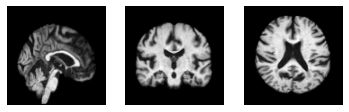

In [19]:
create_and_show_slices(image, "gray")

In [20]:
# resnet_layers = []
# for name, _ in model.named_modules(): 
#     if ("model_resnet" in name):
#         resnet_layers.append(name)
#         # print(name)
        
# print(len(resnet_layers))

In [21]:
# print(resnet_layers[1])

In [22]:
image = torch.unsqueeze(image,0)

In [26]:
import torch
from monai.visualize import CAM, GradCAM



# # cam = CAM(nn_module=model, target_layers="class_layers.relu", fc_layers="class_layers.out")
# # CAM
# cam_shufflenet = CAM(nn_module=model, target_layers="model_shufflenet.base_model.conv_last.2", fc_layers="model_shufflenet.base_model.classifier.1")
# # cam_efficientnet = CAM(nn_module=model, target_layers="model_efficientnet.base_model._conv_head", fc_layers="model_efficientnet.base_model._fc") #)model_efficientnet.base_model._fc
# cam_densenet = GradCAM(nn_module=model, target_layers="model_densenet.base_model.features.conv0")
# cam_resnet = CAM(nn_module=model, target_layers="model_resnet.base_model.layer4.2.conv2", fc_layers="model_resnet.base_model.fc.1")

# # GradCAM first layers
# cam_shufflenet = GradCAM(nn_module=model, target_layers="model_shufflenet.base_model.conv1")
# cam_efficientnet = GradCAM(nn_module=model, target_layers="model_efficientnet.base_model._conv_stem") #)model_efficientnet.base_model._fc
# # cam_densenet = GradCAM(nn_module=model, target_layers="model_densenet.base_model.features.conv0") #)model_densenet
# cam_resnet = GradCAM(nn_module=model, target_layers="model_resnet.base_model.conv1")
# # cam_resnet = GradCAM(nn_module=model, target_layers="base_model.conv1")

# # # # # GradCAM middle layers
# cam_shufflenet = GradCAM(nn_module=model, target_layers="model_shufflenet.base_model.features.8")
# cam_efficientnet = GradCAM(nn_module=model, target_layers="model_efficientnet.base_model._blocks.12._expand_conv") #)model_efficientnet.base_model._fc
# # cam_densenet = GradCAM(nn_module=model, target_layers="model_densenet.base_model.features.denseblock3.denselayer24") #)model_densenet
# cam_resnet = GradCAM(nn_module=model, target_layers="model_resnet.base_model.layer2.3.conv2")
# # cam_resnet = GradCAM(nn_module=model, target_layers="base_model.layer4.2.conv2")

# # # GradCAM last layers
cam_shufflenet = GradCAM(nn_module=model, target_layers="model_shufflenet.base_model.conv_last.2")
cam_efficientnet = GradCAM(nn_module=model, target_layers="model_efficientnet.base_model._conv_head.static_padding") #)model_efficientnet.base_model._fc #module.model_efficientnet.base_model._conv_head
# cam_efficientnet =GradCAM(nn_module=model, target_layers="module.model_efficientnet.base_model._conv_head")

# cam_densenet = GradCAM(nn_module=model, target_layers="model_densenet.base_model.features.norm5") #)model_densenet
cam_resnet = GradCAM(nn_module=model, target_layers="model_resnet.base_model.layer4.2.conv2") #model_resnet.base_model.layer4.2.conv2
# cam_resnet = GradCAM(nn_module=model, target_layers="module.model_resnet.base_model.layer4.2.conv2") #  module.model_resnet.base_model.layer4.1.conv1
# cam_resnet = GradCAM(nn_module=model, target_layers="base_model.layer4.2.conv2")



# mask_densenet = cam_densenet(x=image, class_idx=None, layer_idx = -1)
mask_resnet = cam_resnet(x=image, class_idx=None, layer_idx = -1)
mask_efficientnet = cam_efficientnet(x=image, class_idx=None, layer_idx = -1)
mask_shufflenet = cam_shufflenet(x=image, class_idx=None, layer_idx = -1)

/home/vqtran/miniconda3/envs/summer_thesis/lib/python3.8/site-packages/monai/visualize/class_activation_maps.py:93: UserWarning: Not all target_layers exist in the network module: targets: ('base_model.layer4.2.conv2',).
  warnings.warn(f"Not all target_layers exist in the network module: targets: {self.target_layers}.")


KeyError: 'base_model.layer4.2.conv2'

In [54]:
print(mask_resnet.shape)

torch.Size([1, 1, 110, 110, 110])


# Compute GradCAM over layers 

In [55]:
# zero_tensor = torch.zeros(110,110,110)
# zero_tensor.shape

In [56]:
# import torch
# from monai.visualize import CAM, GradCAM

# # cam = CAM(nn_module=model, target_layers="class_layers.relu", fc_layers="class_layers.out")
# # CAM
# # cam_shufflenet = CAM(nn_module=model, target_layers="model_shufflenet.base_model.conv_last.2", fc_layers="model_shufflenet.base_model.classifier.1")
# # cam_efficientnet = CAM(nn_module=model, target_layers="model_efficientnet.base_model._conv_head", fc_layers="model_efficientnet.base_model._fc") #)model_efficientnet.base_model._fc
# # cam_resnet = CAM(nn_module=model, target_layers="model_resnet.base_model.layer4.2.conv2", fc_layers="model_resnet.base_model.fc.1")

# # GradCAM first layers
# # cam_shufflenet = GradCAM(nn_module=model, target_layers="model_resnet.base_model.conv1")
# # cam_efficientnet = GradCAM(nn_module=model, target_layers="model_efficientnet.base_model._conv_stem") #)model_efficientnet.base_model._fc
# # cam_resnet = GradCAM(nn_module=model, target_layers="model_shufflenet.base_model.conv1")
# # cam_resnet = GradCAM(nn_module=model, target_layers="base_model.conv1")

# # GradCAM last layers
# # cam_shufflenet = GradCAM(nn_module=model, target_layers="model_shufflenet.base_model.conv_last.2")
# # cam_efficientnet = GradCAM(nn_module=model, target_layers="model_efficientnet.base_model._conv_head") #)model_efficientnet.base_model._fc
# cam_resnet = GradCAM(nn_module=model, target_layers="model_resnet.base_model.layer4.2.conv2")
# # cam_resnet = GradCAM(nn_module=model, target_layers="base_model.layer4.2.conv2")

# # mask_shufflenet = cam_shufflenet(x=image, class_idx=2)
# # mask_efficientnet = cam_efficientnet(x=image, class_idx=2)
# mask_resnet = cam_resnet(x=image, class_idx=2)

In [57]:
# zero_tensor += mask_resnet
# print(zero_tensor.mean())

In [58]:
print(mask_shufflenet.shape)
print(mask_efficientnet.shape)
# print(mask_densenet.shape)
print(mask_resnet.shape)

torch.Size([1, 1, 110, 110, 110])
torch.Size([1, 1, 110, 110, 110])
torch.Size([1, 1, 110, 110, 110])


In [61]:
mask_shufflenet = mask_shufflenet.cpu()
mask_efficientnet = mask_efficientnet.cpu()
mask_resnet = mask_resnet.cpu()

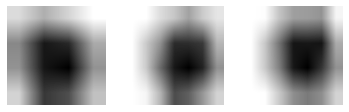

In [62]:
mask_shufflenet = torch.squeeze(mask_shufflenet)

create_and_show_slices(mask_shufflenet, "gray")

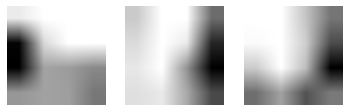

In [63]:
mask_efficientnet = torch.squeeze(mask_efficientnet)

create_and_show_slices(mask_efficientnet, "gray")

In [64]:
# mask_densenet = torch.squeeze(mask_densenet)
# create_and_show_slices(mask_densenet, "gray")

In [65]:
# print(mask_densenet.mean())
# print(mask_densenet.std())
# print(mask_densenet.max())
# print(mask_densenet.std())

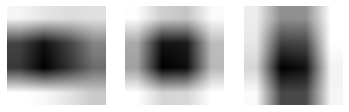

In [66]:
mask_resnet = torch.squeeze(mask_resnet)
create_and_show_slices(mask_resnet, "gray")

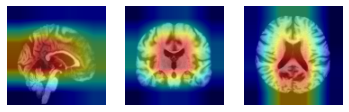

In [67]:
import matplotlib.pyplot as plt

def show_slices_masks(slices, masks, color = "gray"):
    """ Function to display row of image slices """
    if (len(slices) != len(masks)):
        raise ValueError("Slides length and masks length are not equal")

    fig, axes = plt.subplots(1, len(slices))
    
    if color == "gray" or color == "hot" or color == "summer" or color == "jet":
        for i in range(len(slices)):
            plt.axis('off')
            axes[i].imshow(slices[i].T, cmap="gray", origin="lower")
            axes[i].imshow(masks[i].T, cmap=color, alpha=0.5 ,origin="lower")
            axes[i].axis('off')
    else: 
        raise Exception("choose gray, hot, summer, or jet for color")
         
def create_and_show_slices_with_masks(data_volume, mask_volume, color):
    if (len(data_volume.shape) == 4):
        print(data_volume.shape)
        img_data = torch.squeeze(data_volume,0)
    else:
        img_data = data_volume
        
    if (len(mask_volume.shape) == 4):
        print(mask_volume.shape)
        img_mask = torch.squeeze(mask_volume,0)
    else:
        img_mask = mask_volume
        
    slice_0 = img_data[img_data.shape[0]//2, :, :]
    slice_1 = img_data[:, img_data.shape[1]//2, :]
    slice_2 = img_data[:, :, img_data.shape[2]//2]
    
    mask_0 = 1- img_mask[img_mask.shape[0]//2, :, :]
    mask_1 = 1 - img_mask[:, img_mask.shape[1]//2, :]
    mask_2 = 1 - img_mask[:, :, img_mask.shape[2]//2]
    show_slices_masks([slice_0, slice_1, slice_2], [mask_0, mask_1, mask_2],color)
    # plt.suptitle("Center slices for EPI image")  

create_and_show_slices_with_masks(torch.squeeze(image), torch.squeeze(mask_resnet), "jet")

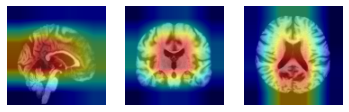

In [68]:
create_and_show_slices_with_masks(torch.squeeze(image), torch.squeeze(mask_resnet), "jet")

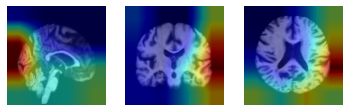

In [69]:
create_and_show_slices_with_masks(torch.squeeze(image), torch.squeeze(mask_efficientnet), "jet")

In [70]:
# create_and_show_slices_with_masks(torch.squeeze(image), torch.squeeze(mask_densenet), "jet")

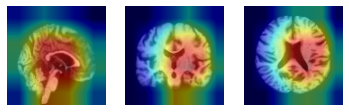

In [71]:
create_and_show_slices_with_masks(torch.squeeze(image), torch.squeeze(mask_shufflenet), "jet")